#Transfer learning ML Project

##Goal:
Learn how to use the pytorch library to perform transfer learning using Resnet50. For this project I specifically trained it on the Food101 dataset which is a dataset containing 101,000 images of food total with 101 classes of food, and some of the training data is poisoned to make it a bit harder to train. For the purposes of my project, I'm not going to sort through data and add a function to filter training data.

Notes: [data set](https://pytorch.org/vision/stable/generated/torchvision.datasets.Food101.html#torchvision.datasets.Food101) - expected to take a LOT of time to download due to sheer size of the data set

~75k images per epoch

#Learning Rates tested:
[Check the [loss rate tracking sheet](https://docs.google.com/spreadsheets/d/14ga3NkQNNMBBGRinW5uz0Z1gpkjMicNn1y9MxqF2Za4/edit?usp=sharing) for progress]

[View loss rate tracking here](https://docs.google.com/spreadsheets/d/14ga3NkQNNMBBGRinW5uz0Z1gpkjMicNn1y9MxqF2Za4/edit?usp=sharing)

#Recorded system requirements:
###Training: 15gb vRAM min.
###Usage: 2gb vRAM min.
###CUDA Compatibility

#Notes
- When I mention "poisoned data", that is referencing purposely mislabeled images in the training data set that throw off accuracy
- groundtruth is another term for the real answer to an image, this is what is used to evaluate accuracy during testing

In [ ]:
import time, copy, enum

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim import lr_scheduler

from torchsummary import summary

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')

device = "cuda" if torch.cuda.is_available() else "cpu"
device

Mounted at /content/gdrive


'cuda'

#Data loaders (Universal)

##Data preparation
###transform:
What is data transformation? It adds variation to every training run of images to randomly alter images so the model consistently gets "new" data it has never seen before increasing overall accuracy of the resulting model.
- 75750 images
- Data *does* contain some incorrect labels to make training harder (courtesy of yours truly, the data set creators)
- Used for training, has random chance to flip training image horizontally (50% default)
- Amplifies and diminishes random color values in training image
- Vertical flipping is generally not advisable for this data set unless I'm going to be dealing with upside down pictures of food

###test_transforms:
- No transforms, all data was checked and 100% accurate
- 25250 images

###Version
Currently set up for 2.0


In [ ]:
#Variables
img_size = 224
batch_size = 128
test_batch_size=1

#define transforms for train and test set
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #Don't mess with the normalize values. resnet prefers these values
    transforms.Resize(img_size, antialias=True), #Set image size to this
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.CenterCrop(img_size) #Ensure image is a square input
    ])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #Don't mess with the normalize values. resnet prefers these values
    transforms.Resize(img_size, antialias=True), #Set image size to this
    transforms.CenterCrop(img_size) #Ensure image is a square input
    ])

# Data loaders
trainSet = torchvision.datasets.Food101(root='./data',
                                        split = 'train',
                                        transform=transform,
                                        download=True)

trainloader = torch.utils.data.DataLoader(trainSet,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)

testSet = torchvision.datasets.Food101(root='./data',
                                        split ='test',
                                        transform=test_transforms,
                                        download=True)

testLoader = torch.utils.data.DataLoader(testSet,
                                          batch_size=test_batch_size,
                                          shuffle=True,
                                          num_workers=2)

#Get classes from the file
classes_path = '/content/data/food-101/meta/classes.txt'

class_file = open(classes_path,'r')
class_data = class_file.read()
classes = class_data.split("\n")
class_file.close()

#function to show images
def imshow(img):
  img = img/2 +.05
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1, 2, 0)))
  plt.show()

#Create iteratable
dataiter = iter(trainloader)


100%|██████████| 4996278331/4996278331 [03:28<00:00, 23997462.94it/s]


Extracting ./data/food-101.tar.gz to ./data


Rerun the cell below if you want to continue looking throught the shuffled training, this is what the model is being trained on every batch - Note: You cannot run this while running other cells

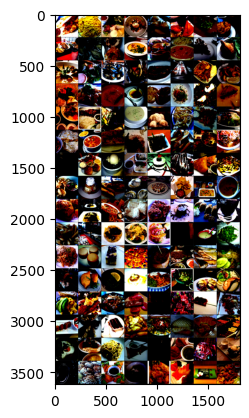

tacos spaghetti_carbonara cheesecake beef_tartare eggs_benedict samosa edamame bread_pudding hot_dog oysters donuts lobster_bisque tacos chicken_curry carrot_cake samosa mussels caesar_salad mussels falafel prime_rib sushi pad_thai fried_calamari seaweed_salad poutine baklava creme_brulee bruschetta shrimp_and_grits poutine baklava bibimbap peking_duck greek_salad clam_chowder dumplings french_fries fried_calamari caesar_salad chicken_quesadilla hot_and_sour_soup garlic_bread crab_cakes seaweed_salad french_fries bibimbap pho   beef_tartare crab_cakes bread_pudding pho   red_velvet_cake french_toast samosa nachos beef_tartare strawberry_shortcake grilled_cheese_sandwich oysters takoyaki nachos fried_rice lobster_bisque crab_cakes spaghetti_bolognese lobster_roll_sandwich beignets apple_pie chocolate_mousse baklava miso_soup poutine takoyaki escargots caesar_salad tacos seaweed_salad miso_soup greek_salad pad_thai macarons cheese_plate samosa grilled_cheese_sandwich bibimbap garlic_brea

In [ ]:
#Display new image
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

#Create model (7.0) - Don't execute if loading file from save
Creating the resnet50 based model, using SGD Optimizer, Adagrad, and Adam optimizer, and using cross entropy loss as the loss function to create a confidence focused model

Using a pre-trained resnet50 model trained on images from imagenet means I don't need to worry about teaching the model things from ground up

SGD Hyperparameters were tuned according to best performance by other people and from the accuracy tracker found at the top of the notebook

In [ ]:
#create model
from torchvision.models import ResNet50_Weights
model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)

num_features = model.fc.in_features

#Set to true during training
for param in model.parameters():
  param.requires_grad=True

model.fc = nn.Linear(num_features, 102)

#Loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001) #iteration 7.0
#optimizer = optim.Adadelta(model.parameters(), lr=.01, weight_decay=0.0001) #iteration 8.t2

learn_rate = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3)

#move model to cuda
if torch.cuda.is_available():
    model.cuda()

cur_epochs = 0

#summary(model, input_size=(3, img_size, img_size)) #Uncomment to view model layers & structure

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 140MB/s]


#Training (7.0)
Training happens in epochs where an epoch is like a deck of flashcards you're showing to the model to guess. A forward pass is done to evaluate the state of the model, Backpropagation is effectively taking the losses and sending them to an optimizer to modify the model further
##Output order:

 - Epoch: Cycles of training
 - Number of data points trained on
 - Loss: How far model is off from regression
 - TSSoE: Time since start of execution

In [ ]:
running_loss = 0.0
model.to(device)

base_time = time.time()
i = 0

#number of times to train the data set also called epochs
train_session_epochs = 5

with torch.enable_grad():
  for epoch in range(train_session_epochs):
    running_loss = 0.0
    cur_epochs += 1

    for inputs, labels in trainloader:
      i = i+1

      #move to gpu
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero parameter gradients
      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      loss.cuda()
      optimizer.step()

      #print stats
      running_loss += loss.item()
      if i % 592 == 591:
        print(f'[{cur_epochs}, {i + 1:5d} Loss: {running_loss / 591:.5f}, TSSoE: {(time.time()-base_time)/60:.2f}]')
        running_loss = 0.0

print(f"Finished training: {(time.time()-base_time)/60:.2f}, Final loss: {running_loss / 591:.5f}")

NameError: name 'trainloader' is not defined

# Save model (7.0)
Use this to save the model to a folder called "resnetPIzzer" as a pt and pth file (both should be able to used for loading)
Dictionary setup:
- "epoch" - Current epoch the model last finished on
- "model_state_dict" - Model state the last time it was saved
- "optimizer_state_dict" - Optimizer state at the time of last model save

In [ ]:
import os

# Define the path
directory_path = '/content/gdrive/MyDrive/resnetPIzzer'

# Check if the directory exists, if not, create it
if not os.path.exists(directory_path):
    os.makedirs(directory_path)


#Saving files into files for training or testing later
GDRIVEPATH_pth = F"/content/gdrive/MyDrive/resnetPIzzer/pizzerE1SGD01-128MB.pth"
GDRIVEPATH_pt = F"/content/gdrive/MyDrive/resnetPIzzer/pizzerE1SGD01-128MB.pt"

checkpoint_pth = torch.save({
            'epoch': cur_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, GDRIVEPATH_pth)

checkpoint_pt = torch.save({
            'epoch': cur_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, GDRIVEPATH_pt)

#Load model from save
Load once, refer to *Save model* for information on the schema, this is effecively just setting up the model and unpacking the last state from the file it was saved as so training doesn't need to happen every time.


In [ ]:
#run to empty gpu cache
torch.cuda.empty_cache()

In [ ]:
#Load checkpoint
CHECKPOINT_PATH = F"/content/gdrive/MyDrive/resnetPIzzer/pizzerE1SGD01-128MB.pth"
checkpoint = torch.load(CHECKPOINT_PATH)

#Set up base model
from torchvision.models import ResNet50_Weights
model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)

optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0001)
#optimizer = optim.Adadelta(model.parameters(), lr=.01, weight_decay=0.0001) #iteration 8.t2
learn_rate = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 102)

if torch.cuda.is_available():
    model.cuda()

#Set to True for training, set to false for testing
for param in model.parameters():
  param.requires_grad=False

#Load previous states
cur_epochs = checkpoint['epoch']
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.load_state_dict(checkpoint['model_state_dict'])

criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 81.3MB/s]


#Test Run
Load data once, then cycle through data set with the second function. At this point, reducing batch size and re-loading to reduce visual clutter is fine, however, you will need to reset the batch size afterwards if you intend to keep training for the sake of consistency

In [ ]:
#Load data into an iteration object
dataiter2 = iter(testLoader)

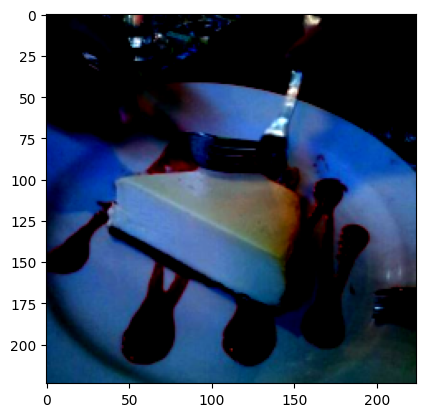

GroundTruth:  cheese_plate
predicted:  cheese_plate


In [ ]:
#Go through iteration object to view images and predictions
images2, labels2 = next(dataiter2)

images2.to(device)
labels2.to(device)

imshow(torchvision.utils.make_grid(images2))
print('GroundTruth: ', ' '.join(f'{classes[labels2[j]]:5s}' for j in range(test_batch_size)))

outputs = model(images2.to(device))
_, predicted = torch.max(outputs, 1)

print('predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(test_batch_size)))

#Model accuracy
## Accuracy Overall
Records:

top1: ~85% - SGD01-128M

top5: ~97% - SGD01-128M


In [ ]:
correct_prediction = {classname: 0 for classname in classes}
total_prediction = {classname: 0 for classname in classes}

#Set to evaulation mode
model.eval()

with torch.no_grad():
  for data in testLoader:

    images, labels = data
    images.to(device)
    labels.to(device)

    outputs = model(images.to(device))
    _, predictions = torch.max(outputs, 1)

    #collect the correct predictions for each class
    for label, prediction in zip(labels, predictions):
      if label == prediction:
        correct_prediction[classes[label.to(device)]] += 1
      total_prediction[classes[label.to(device)]] += 1

for classname, correct_count in correct_prediction.items():
   if classname != '':
     accuracy = 100 * float(correct_count) / total_prediction[classname]
     print(f'Accuracy for class: {classname:5s} is {accuracy:.2f} %')

Accuracy for class: apple_pie is 54.00 %
Accuracy for class: baby_back_ribs is 87.60 %
Accuracy for class: baklava is 85.20 %
Accuracy for class: beef_carpaccio is 82.40 %
Accuracy for class: beef_tartare is 82.00 %
Accuracy for class: beet_salad is 80.80 %
Accuracy for class: beignets is 87.20 %
Accuracy for class: bibimbap is 89.60 %
Accuracy for class: bread_pudding is 53.60 %
Accuracy for class: breakfast_burrito is 70.40 %
Accuracy for class: bruschetta is 74.80 %
Accuracy for class: caesar_salad is 93.60 %
Accuracy for class: cannoli is 93.20 %
Accuracy for class: caprese_salad is 77.60 %
Accuracy for class: carrot_cake is 85.60 %
Accuracy for class: ceviche is 50.80 %
Accuracy for class: cheesecake is 79.60 %
Accuracy for class: cheese_plate is 68.80 %
Accuracy for class: chicken_curry is 73.60 %
Accuracy for class: chicken_quesadilla is 86.40 %
Accuracy for class: chicken_wings is 88.80 %
Accuracy for class: chocolate_cake is 79.60 %
Accuracy for class: chocolate_mousse is 66.0

#Evaluate top_k
IMPORTANT: SET BATCH SIZE TO 1 BEFORE EVALUATION

In [ ]:
def evaluate_topk(model, test_loader, k=5):
  """Evaluate the top-k accuracy of a model on the test set."""
  correct = 0
  total = 0

  model.eval()

  with torch.no_grad():
    for data in test_loader:
      images, labels = data

      outputs = model(images.to(device))

      _, predicted = torch.topk(outputs, k, dim=1)
      total += labels.size(0)
      correct += (predicted == labels.to(device)).sum().item()

  return correct / total


In [ ]:
evaluate_topk(model, testLoader, k=1)

0.8218613861386138

In [ ]:
evaluate_topk(model, testLoader)

0.9602376237623762

#Results: What did I produce?
- I made an AI that can differenciate 101 different types of food, this is interactable with in [this Notebook](https://colab.research.google.com/drive/1z2gY2DQzOqxu-ArJWNTiRGr3NHp8hbQu?usp=sharing)
- The model has a top1 accuracy of ~82.19% which upon investigating and comparing with other projects is fairly competitive using ~40-50 epochs
- The model has a top5 accuracy of ~96.02%
  - Top5 describes the top 5 predictions of the model on what it thinks an image is, that means based on this metric, the model gets ~97% of its predictions correct in the top 5 things it thinks an image is

Source of top1 comparisons:
- [Comparison 1: ~86%](https://github.com/Herick-Asmani/Food-101-classification-using-ResNet-50/blob/master/Food101challenge.ipynb)
- [Comparison 2: ~84%](https://jovian.com/rivsonmoraes/food101_complete_resnet50)

#What could be done to learn more?
- investigating how accuracy changes with different sizes of models (eg. Resnet200, resnet152, etc.)
- learning how to design a model from scratch would be a longer term goal
- learning how LLMs train without a groundtruth is also something that is interesting; classification models/projects typically have a set of data to evaulate performance of a model, but LLMs are generative so there's not exactly a groundtruth to tell if it's spouting nonsense or forming coherent sentences
- Modifying training data manually to remove poisoned data to increase accuracy would also be an interesting project to look at

#What were some constraints encountered with the project?
- restriction of vRAM from using google colab restricted the size of model I could use, as well as the resolution of pictures.
- Preferably I would use something other than a T4 gpu to train, but it's the most powerful thing I have available without spending extra money
- Restriction in training time allowed per sesion is something I had to work around by using multiple google accounts